# ProcessOptimize examples

Sigurd carlsen 20 feb 2019

This notebook serves to showcase the new features that are being added to the scikit-optimize fork: ProcessOptimizer

In [61]:
# We append to system path as we are not using the pip version of ProcessOptimizer. 
# Be sure to inser the correct path to ProcessOptimizer here:

#import sys
#sys.path.append('/home/sigurd/dev/ProcessOptimizer')
from ProcessOptimizer.benchmarks import branin as branin
from ProcessOptimizer.benchmarks import hart6 as hart6_
from ProcessOptimizer.plots import plot_objective
from ProcessOptimizer import gp_minimize, forest_minimize, dummy_minimize
from ProcessOptimizer import plots
from ProcessOptimizer.plots import _evenly_sample
from ProcessOptimizer.space import Space
import time

In [62]:
# For reproducibility
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.set_cmap("viridis")

<Figure size 432x288 with 0 Axes>

# plot_objective

Plot objective now supports optional use of partial dependence as well as different methods of defining parameter values for dependency plots

In [63]:
# Here we define a function that we evaluate.
def funny_func(x):
    s = 0
    for i in range(len(x)):
        s += (x[i]*i)**2
    return s

In [64]:
# We run forest_minimize on the function
bounds = [(-1, 1.),] * 4
n_calls = 20
result = gp_minimize(funny_func, bounds, n_calls=40)

Here we see an example of using partial dependence. Even when setting n_points all the way down to 10 from the default of 40, this method is still very slow. This is because partial dependence calculates 250 extra predictions for each point on the plots.

In [195]:
space = Space(bounds)
model = result.models[-1]
i=0
j=None
sample_points=None
n_samples=100
n_points=10
x_eval = None

In [196]:
a=time.time()
yi = dependence(space, model, i, j=j, sample_points=sample_points,
                       n_samples=n_samples, n_points=n_points, x_eval = x_eval)
print("time old : " + str(time.time()-a))
a=time.time()
yi = new_dependence(space, model, i, j=j, sample_points=sample_points,
                       n_samples=n_samples, n_points=n_points, x_eval = x_eval)
print("time new : " + str(time.time()-a))

time old : 0.0054931640625
time new : 0.003492593765258789


In [197]:
# to transformed (model) dimensions.

# If we havent parsed an x_eval list we use random sampled values instead
if x_eval is None:
    sample_points = space.transform(space.rvs(n_samples=n_samples))
else:
    sample_points = space.transform([x_eval])

# dim_locs[i] is the (column index of the) start of dim i in sample_points.
# This is usefull when we are using one hot encoding, i.e using categorical values
dim_locs = np.cumsum([0] + [d.transformed_size for d in space.dimensions])

In [198]:
if j is None:
    # We sample evenly instead of randomly. This is necessary when using
    # categorical values
    xi, xi_transformed = _evenly_sample(space.dimensions[i], n_points)
    yi = []
    for x_ in xi_transformed:
        rvs_ = np.array(sample_points)      # copy
        # We replace the values in the dimension that we want to keep fixed
        rvs_[:, dim_locs[i]:dim_locs[i + 1]] = x_ 
        # In case of `x_eval=None` rvs conists of random samples.
        # Calculating the mean of these samples is how partial dependence
        # is implemented.
        yi.append(np.mean(model.predict(rvs_)))



else:
    xi, xi_transformed = _evenly_sample(space.dimensions[j], n_points)
    yi, yi_transformed = _evenly_sample(space.dimensions[i], n_points)

    zi = []
    for x_ in xi_transformed:
        row = []
        for y_ in yi_transformed:
            rvs_ = np.array(sample_points)      # copy
            rvs_[:, dim_locs[j]:dim_locs[j + 1]] = x_
            rvs_[:, dim_locs[i]:dim_locs[i + 1]] = y_
            row.append(np.mean(model.predict(rvs_)))
        zi.append(row)

In [199]:
xi, xi_transformed = _evenly_sample(space.dimensions[i], n_points)
yi = []


rvs_all_ = np.zeros([n_samples*n_points,len(dim_locs)-1])
for i_points in range(n_points):
    x_ = xi_transformed[i_points]
    
    rvs_ = np.array(sample_points)      # copy
    # We replace the values in the dimension that we want to keep fixed
    rvs_[:, dim_locs[i]:dim_locs[i + 1]] = x_  
    rvs_all_[i_points*n_samples:(i_points+1)*n_samples,:] = rvs_
    # In case of `x_eval=None` rvs conists of random samples.
    # Calculating the mean of these samples is how partial dependence
    # is implemented.
    
predictions = model.predict(rvs_all_)
for i_points in range(n_points):
    yi.append(np.mean(predictions[i_points*n_samples:(i_points+1)*n_samples]))

In [145]:
yiNew = yi

In [147]:
yiNew == yi

False

In [156]:
yiNew[8]

18.536460682673727

In [157]:
yi[8]

18.536460682673727

In [140]:
np.mean(model.predict(rvs_))

18.55725389144855

In [139]:
rvs_all_

array([[-1.        , -0.83644348,  0.17536625,  0.01116621],
       [-1.        , -0.81086254, -0.47680427, -0.33058729],
       [-1.        ,  0.36974476, -0.61352029, -0.24970148],
       ...,
       [ 1.        ,  0.38525138,  0.6535335 , -0.47890236],
       [ 1.        ,  0.82952908,  0.2068714 , -0.58548328],
       [ 1.        , -0.41710308,  0.32962942, -0.74189122]])

In [117]:
a=np.array([1,2,3,4,5,6,7,8,9,10,11,12])

In [122]:
for i in range(3):
    print(a[i*4:(i+1)*4,])


[1 2 3 4]
[5 6 7 8]
[ 9 10 11 12]


In [120]:
a[0:4]

array([1, 2, 3, 4])

In [121]:
a[4:8]

array([5, 6, 7, 8])

In [114]:
n_points

40

In [113]:
np.shape(xi_transformed)

(40,)

In [108]:
np.shape(rvs_)

(1000, 4)

In [111]:
np.shape(rvs_[0:2,:])

(2, 4)

In [106]:
rvs_all_[1:2,:]

array([[0., 0., 0., 0.]])

In [98]:
len(dim_locs)

5

In [ ]:
np.append()

In [103]:
np.shape(rvs2)

(1000, 4)

In [97]:
rvs2.append(rvs_)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [95]:
rvs2 = rvs_

In [ ]:
rvs

In [86]:
len(xi)

40

In [82]:
yi

[18.512420808345713,
 18.513008894358304,
 18.51360077473212,
 18.514196447703434,
 18.51479591147577,
 18.515399164224327,
 18.51600620410258,
 18.51661702923099,
 18.517231637708793,
 18.517850027602837,
 18.51847219695527,
 18.51909814378508,
 18.519727866081826,
 18.52036136181273,
 18.520998628913773,
 18.521639665297684,
 18.52228446885755,
 18.522933037448755,
 18.523585368914784,
 18.524241461064296,
 18.524901311684467,
 18.525564918539718,
 18.52623227936647,
 18.52690339187994,
 18.52757825376602,
 18.52825686269215,
 18.52893921629699,
 18.529625312194927,
 18.53031514798303,
 18.531008721224666,
 18.53170602946697,
 18.53240707022736,
 18.533111841008125,
 18.533820339274854,
 18.534532562483896,
 18.53524850805819,
 18.535968173399567,
 18.536691555888094,
 18.53741865288077,
 18.538149461709697]

In [80]:
yiBase

[18.512420808345713,
 18.513008894358304,
 18.51360077473212,
 18.514196447703434,
 18.51479591147577,
 18.515399164224327,
 18.51600620410258,
 18.51661702923099,
 18.517231637708793,
 18.517850027602837,
 18.51847219695527,
 18.51909814378508,
 18.519727866081826,
 18.52036136181273,
 18.520998628913773,
 18.521639665297684,
 18.52228446885755,
 18.522933037448755,
 18.523585368914784,
 18.524241461064296,
 18.524901311684467,
 18.525564918539718,
 18.52623227936647,
 18.52690339187994,
 18.52757825376602,
 18.52825686269215,
 18.52893921629699,
 18.529625312194927,
 18.53031514798303,
 18.531008721224666,
 18.53170602946697,
 18.53240707022736,
 18.533111841008125,
 18.533820339274854,
 18.534532562483896,
 18.53524850805819,
 18.535968173399567,
 18.536691555888094,
 18.53741865288077,
 18.538149461709697]

In [79]:
yi

[18.512420808345713,
 18.513008894358304,
 18.51360077473212,
 18.514196447703434,
 18.51479591147577,
 18.515399164224327,
 18.51600620410258,
 18.51661702923099,
 18.517231637708793,
 18.517850027602837,
 18.51847219695527,
 18.51909814378508,
 18.519727866081826,
 18.52036136181273,
 18.520998628913773,
 18.521639665297684,
 18.52228446885755,
 18.522933037448755,
 18.523585368914784,
 18.524241461064296,
 18.524901311684467,
 18.525564918539718,
 18.52623227936647,
 18.52690339187994,
 18.52757825376602,
 18.52825686269215,
 18.52893921629699,
 18.529625312194927,
 18.53031514798303,
 18.531008721224666,
 18.53170602946697,
 18.53240707022736,
 18.533111841008125,
 18.533820339274854,
 18.534532562483896,
 18.53524850805819,
 18.535968173399567,
 18.536691555888094,
 18.53741865288077,
 18.538149461709697]

In [77]:
yiBase = yi

In [60]:
tStart = time.time()
i=0
a = dependence(space.Space(bounds),result.models[-1],i,j=2, sample_points=None,
                       n_samples=1000, n_points=40, x_eval = None)
print("job took "+str(time.time()-tStart)+" seconds")

job took 3.736689805984497 seconds


job took 1.397944450378418 seconds


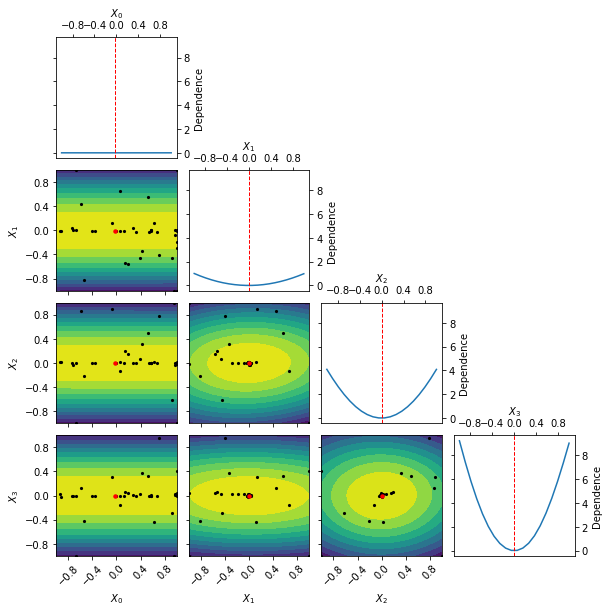

In [50]:
tStart = time.time()
_ = plot_objective(result,usepartialdependence = False, n_points = 20)
print("job took "+str(time.time()-tStart)+" seconds")

Here we plot without partial dependence. We see that it is a lot faster. Also the values for the other parameters are set to the default "result" which is the parameter set of the best observed value so far. In the case of funny_func this is close to 0 for all parameters.

In [31]:
result.models[-1]

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
             kernel=1**2 * Matern(length_scale=[1, 1, 1, 1], nu=2.5) + WhiteKernel(noise_level=1),
             n_restarts_optimizer=2, noise='gaussian', normalize_y=True,
             optimizer='fmin_l_bfgs_b', random_state=445654016)

In [35]:
bounds

[(-1, 1.0), (-1, 1.0), (-1, 1.0), (-1, 1.0)]

In [45]:
space.Space(bounds)

Space([Real(low=-1, high=1.0, prior='uniform', transform='identity'),
       Real(low=-1, high=1.0, prior='uniform', transform='identity'),
       Real(low=-1, high=1.0, prior='uniform', transform='identity'),
       Real(low=-1, high=1.0, prior='uniform', transform='identity')])

In [48]:
a = dependence(space.Space(bounds),result.models[-1],0)

(array([-1.        , -0.94871795, -0.8974359 , -0.84615385, -0.79487179,
        -0.74358974, -0.69230769, -0.64102564, -0.58974359, -0.53846154,
        -0.48717949, -0.43589744, -0.38461538, -0.33333333, -0.28205128,
        -0.23076923, -0.17948718, -0.12820513, -0.07692308, -0.02564103,
         0.02564103,  0.07692308,  0.12820513,  0.17948718,  0.23076923,
         0.28205128,  0.33333333,  0.38461538,  0.43589744,  0.48717949,
         0.53846154,  0.58974359,  0.64102564,  0.69230769,  0.74358974,
         0.79487179,  0.84615385,  0.8974359 ,  0.94871795,  1.        ]),
 [20.437347699543338,
  20.437154332028985,
  20.43696411070879,
  20.436777037293993,
  20.436593113473055,
  20.43641234090292,
  20.436234721208248,
  20.436060255977697,
  20.43588894677659,
  20.435720795135296,
  20.4355558025524,
  20.43539397050099,
  20.435235300410824,
  20.435079793693518,
  20.43492745172703,
  20.434778275849553,
  20.4346322673796,
  20.434489427600138,
  20.434349757766867,
  20.

In [ ]:
xi, xi_transformed = _evenly_sample(space.dimensions[i], n_points)
yi = []


rvs_all_ = []
for i_points in range(n_points):
    x_ = xi_transformed[i_points]
    
    rvs_ = np.array(sample_points)      # copy
    # We replace the values in the dimension that we want to keep fixed
    rvs_[:, dim_locs[i]:dim_locs[i + 1]] = x_  
    rvs_all_[i_points*n_samples:(i_points+1)*n_samples,:] = rvs_
    # In case of `x_eval=None` rvs conists of random samples.
    # Calculating the mean of these samples is how partial dependence
    # is implemented.
    
predictions = model.predict(rvs_all_)
for i_points in range(n_points):
    yi.append(np.mean(predictions[i_points*n_samples:(i_points+1)*n_samples]))

In [166]:
def new_dependence(space, model, i, j=None, sample_points=None,
                       n_samples=250, n_points=40, x_eval = None):
    
    # to transformed (model) dimensions.

    # If we havent parsed an x_eval list we use random sampled values instead
    if x_eval is None:
        sample_points = space.transform(space.rvs(n_samples=n_samples))
    else:
        sample_points = space.transform([x_eval])

    # dim_locs[i] is the (column index of the) start of dim i in sample_points.
    # This is usefull when we are using one hot encoding, i.e using categorical values
    dim_locs = np.cumsum([0] + [d.transformed_size for d in space.dimensions])

    if j is None:
        # We sample evenly instead of randomly. This is necessary when using
        # categorical values
        xi, xi_transformed = _evenly_sample(space.dimensions[i], n_points)
        yi = []


        rvs_all_ = np.zeros([n_samples*n_points,len(dim_locs)-1])
        for i_points in range(n_points):
            x_ = xi_transformed[i_points]

            rvs_ = np.array(sample_points)      # copy
            # We replace the values in the dimension that we want to keep fixed
            rvs_[:, dim_locs[i]:dim_locs[i + 1]] = x_  
            rvs_all_[i_points*n_samples:(i_points+1)*n_samples,:] = rvs_
            # In case of `x_eval=None` rvs conists of random samples.
            # Calculating the mean of these samples is how partial dependence
            # is implemented.

        predictions = model.predict(rvs_all_)
        for i_points in range(n_points):
            yi.append(np.mean(predictions[i_points*n_samples:(i_points+1)*n_samples]))

        return xi, yi

    else:
        xi, xi_transformed = _evenly_sample(space.dimensions[j], n_points)
        yi, yi_transformed = _evenly_sample(space.dimensions[i], n_points)

        zi = []
        for x_ in xi_transformed:
            row = []
            for y_ in yi_transformed:
                rvs_ = np.array(sample_points)      # copy
                rvs_[:, dim_locs[j]:dim_locs[j + 1]] = x_
                rvs_[:, dim_locs[i]:dim_locs[i + 1]] = y_
                row.append(np.mean(model.predict(rvs_)))
            zi.append(row)

        return xi, yi, np.array(zi).T

In [29]:
def dependence(space, model, i, j=None, sample_points=None,
                       n_samples=250, n_points=40, x_eval = None):
    
    # to transformed (model) dimensions.

    # If we havent parsed an x_eval list we use random sampled values instead
    if x_eval is None:
        sample_points = space.transform(space.rvs(n_samples=n_samples))
    else:
        sample_points = space.transform([x_eval])

    # dim_locs[i] is the (column index of the) start of dim i in sample_points.
    # This is usefull when we are using one hot encoding, i.e using categorical values
    dim_locs = np.cumsum([0] + [d.transformed_size for d in space.dimensions])

    if j is None:
        # We sample evenly instead of randomly. This is necessary when using
        # categorical values
        xi, xi_transformed = _evenly_sample(space.dimensions[i], n_points)
        yi = []
        for x_ in xi_transformed:
            rvs_ = np.array(sample_points)      # copy
            # We replace the values in the dimension that we want to keep fixed
            rvs_[:, dim_locs[i]:dim_locs[i + 1]] = x_ 
            # In case of `x_eval=None` rvs conists of random samples.
            # Calculating the mean of these samples is how partial dependence
            # is implemented.
            yi.append(np.mean(model.predict(rvs_)))

        return xi, yi

    else:
        xi, xi_transformed = _evenly_sample(space.dimensions[j], n_points)
        yi, yi_transformed = _evenly_sample(space.dimensions[i], n_points)

        zi = []
        for x_ in xi_transformed:
            row = []
            for y_ in yi_transformed:
                rvs_ = np.array(sample_points)      # copy
                rvs_[:, dim_locs[j]:dim_locs[j + 1]] = x_
                rvs_[:, dim_locs[i]:dim_locs[i + 1]] = y_
                row.append(np.mean(model.predict(rvs_)))
            zi.append(row)

        return xi, yi, np.array(zi).T